# Table of contents

# Description of the problem and data

In this competition/assigment, I am creating a CNN based deep learning algorithm to be able to do binary classification in order to identify metastatic cancer in small image patches taken from digital pathology scans. The data from this competition is  a slightly modified version of the PatchCamelyon (PCam) benchmark dataset, but this copy does not contain duplicates. My model will predict the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image. A model like this could speed up the task of clinicians in being able to identify metastatic cancer by flagging the images with high likelihood of cancer for futher clinician examination.

# Utils section

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.image as mpimg
import os
import matplotlib.patches as patches
import tensorflow as tf
# Check GPU is available to train
gpus = tf.config.list_physical_devices('GPU')
gpu_available = len(gpus) > 0

print(f"Is GPU available? {gpu_available}")

if gpu_available:
    # TensorFlow often lists devices generally, getting the specific name usually requires
    # specific queries or reliance on standard output logs, but we can print the device details.
    print(f"GPU Devices: {gpus}")
    # For specific name details, TF usually relies on nvidia-smi, 
    # but the device handle is:
    print(f"Device details: {tf.test.gpu_device_name()}")
else:
    print("GPU Name: None")

import keras

# load the train_labels.csv file to see data structure and plot distribution of labels
df_train_labels = pd.read_csv("histopathologic-cancer-detection/train_labels.csv")

# directories for the train and test labels
test_dir = 'histopathologic-cancer-detection/test'
train_dir = 'histopathologic-cancer-detection/train'

# Get a random positive and a random negative label
rand_pos_set = df_train_labels[df_train_labels.label == 1]
rand_pos = rand_pos_set.iloc[random.randint(0, rand_pos_set.shape[0]), :].id
rand_neg_set = df_train_labels[df_train_labels.label == 0]
rand_neg = rand_neg_set.iloc[random.randint(0, rand_neg_set.shape[0]), :].id

def get_channel_values(id_list, train_dir):
    """this function needs a series of IDs for extractinng the image data"""
    # keep all of the necessary imports within the function if they habe not been created within the doc yet
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import random
    import matplotlib.image as mpimg
    import os

    # extract the values of each channel: red, green and blue
    # iterate over all of the given IDs

    # create empty numpy arrays to hold all of the pixels for each channel
    # calculate size of the arrays
    size = mpimg.imread(train_dir + '/' + id_list[0] + '.tif')[:, :, 0].flatten().shape[0] * id_list.shape[0]
    mini_size = mpimg.imread(train_dir + '/' + id_list[0] + '.tif')[:, :, 0].flatten().shape[0]
    level_size = id_list.shape[0]
    level_step_jumps = list(range(0, mini_size*size, mini_size))
    red_dist = np.zeros(size)
    green_dist = np.zeros(size)
    blue_dist = np.zeros(size)

    # Fill the empty arrays
    for level_jump  in range(level_size):
        for id_sample in id_list:
            image_loaded = mpimg.imread(train_dir + '/' + id_sample + '.tif')
            red_pixels = image_loaded[:, :, 0]
            green_pixels =  image_loaded[:, :, 1]
            blue_pixels =  image_loaded[:, :, 2]
            red_dist[level_jump*mini_size:(level_jump+1)*mini_size]= red_pixels.flatten()
            green_dist[level_jump*mini_size:(level_jump+1)*mini_size]= green_pixels.flatten()
            blue_dist[level_jump*mini_size:(level_jump+1)*mini_size]= blue_pixels.flatten()
    return red_dist, green_dist, blue_dist


def normalize_input_data(training_data, validation_data, directory, shuffle=True):
    """This function normalizes the input data in order to facilitate with the training process
    and also takes advantage of keras functionality to load data as the training progresses"""
    # from keras_preprocessing.image import ImageDataGenerator
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    data_gen_for_train = ImageDataGenerator(rescale=1.0/255, 
                                            rotation_range=45, 
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            horizontal_flip=True,
                                            vertical_flip=True)
    # Just normalize the validation data but do not generate any extra data
    data_gen_for_validation = ImageDataGenerator(rescale=1.0/255)
    
    # process the data on memory with the given ID value information
    BATCH_SIZE = 256
    image_size = (96,96)
    # Load the training data
    train_loaded = data_gen_for_train.flow_from_dataframe(
        dataframe=training_data,
        directory=directory,
        x_col='id', 
        y_col='label',
        target_size=image_size,
        batch_size=BATCH_SIZE,
        class_mode='binary', # Because we have 0 vs 1; np
        shuffle=shuffle
    )

    # Do the same with the validation data
    validation_loaded = data_gen_for_validation.flow_from_dataframe(
        dataframe=validation_data,
        directory=directory,
        x_col='id',
        y_col='label',
        target_size=image_size,
        batch_size=BATCH_SIZE,
        class_mode='binary' ,
        shuffle=shuffle
    )


    return train_loaded, validation_loaded

def divide_input_data(input_data, random_state=42):
    """This function divides the training data labels into a training and validation set in order
    to facilitate with the process of model training and validation"""
    from sklearn.model_selection import train_test_split
    # get the labels from the input data
    input_data = input_data.copy()
    labels = input_data['label'].astype(str) # this will be used to stratify the data to ensure the train and validation splits are appropriate
    # need to also convert the label data to strings to align with  keras documentation
    input_data['label'] = input_data['label'].astype(str)
    # divide the labels between the train and validation set using sklearn's function
    # add .tif to the ids so that it is easier to to the keras data flow
    input_data ['id'] = input_data['id'].apply(lambda x: x + '.tif')
    df_train_only, df_validation_only = train_test_split(input_data, test_size=0.2, train_size = 0.8, random_state=random_state, stratify=labels)
    return df_train_only, df_validation_only

def model_plot_generation(model_fit_instance, type_of_metric, val_loader=None):
    """ this function needs a history instance of the training of a model or the evaluation of a model with
    validation or test data in order to plot some key metrics about the model"""
    from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Access key metrics
    if type_of_metric == "validation":
        # then use the .predict() raw results to do all of the plotting
        # then we only have acccess to the validation data and not training data
        # print the metrics, do confusion matrix, do some plotting
        # Fix the shuffle of the classes to get y_pred and y_true i n the same order
        # 1. Configure for Inference (Speed Mode)
        y_pred = (model_fit_instance.ravel()>0.5).astype(int)
        y_true = val_loader.classes
        
        # Do confusion matrix of validation data and print accuracy value
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        # Calculate accuracy
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Validation Accuracy: {accuracy:.4f}")

    elif type_of_metric == "training":
        # then use the csv file created for it
        # then we have training data, and we can plot history related information 
        # for the different epochs
        import pandas as pd
        history_df = pd.read_csv(model_fit_instance)
        history_df[['accuracy', 'val_accuracy']].plot()
        plt.title('Accuracy training vs validation')
        history_df[['auc', 'val_auc']].plot()
        plt.title('AUC training vs validation')
        print(f"the training accuracy of the model is {history_df['accuracy']}")
    else:
        # whatever was added to the function input is not supported
        return "Input either a validation or a training metric; note that testing data  should use validation"

Is GPU available? True
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device details: /device:GPU:0


# Exploratory Data Analysis(EDA) - Inspect, visualize and clean the data

For the EDA, I plan to do the following:

* Show a random positive and negative label just to get a sense of what the data looks like. Also draw a square around the 32x32 pixels where the classification would need to be made
* Show a pie chart with the percentage of positive vs negative lebels
* Show some information/descriptive stats on the pixels of the training data

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


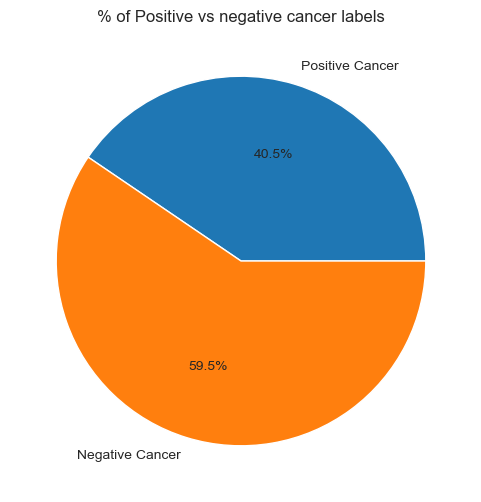

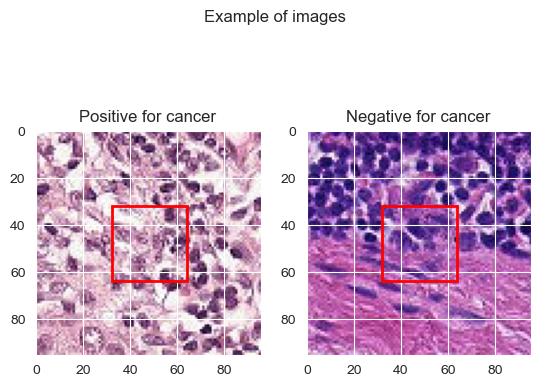

In [2]:
# Display the first 5 rows of the dataframe of the labels
print(df_train_labels.head())

# Plot the distribution of positive and negative labels in the training data with a pie chart

# Get the data
pos_cancer_label = df_train_labels[df_train_labels['label'] == 1]
neg_cancer_label = df_train_labels[df_train_labels['label'] == 0]
pos_per = pos_cancer_label.shape[0]*100/df_train_labels.shape[0]
neg_per = neg_cancer_label.shape[0]*100/df_train_labels.shape[0]
data_pie = [pos_per, neg_per]
labels = ["Positive Cancer", "Negative Cancer"]

# do the plotting
sns.set_style("darkgrid")
plt.figure(figsize=(6,6))
plt.pie(data_pie, labels = labels, autopct='%1.1f%%')
plt.title('% of Positive vs negative cancer labels')
plt.show()

# Plot an example of an image with a negative and a positive label

# Read an image using the path already define above as well as the random ID that I already obtained
img_pos = mpimg.imread(train_dir + '/' + rand_pos + '.tif')
img_neg = mpimg.imread(train_dir + '/' + rand_neg + '.tif')

# Display the images
fig, axs = plt.subplots(1, 2)
fig.suptitle('Example of images')
axs[0].imshow(img_pos)
axs[0].set_title("Positive for cancer")
axs[1].imshow(img_neg)
axs[1].set_title("Negative for cancer")


# Add a box on the center
rect_0 = patches.Rectangle((32, 32), 32, 32, linewidth=2, edgecolor='r', facecolor='none')
axs[0].add_patch(rect_0)
rect_1 = patches.Rectangle((32, 32), 32, 32, linewidth=2, edgecolor='r', facecolor='none')
axs[1].add_patch(rect_1)

Images have the following shape when loaded (96, 96, 3)
The minimum pixel value is 0 and max is 255 so we are dealing with 8 bit images


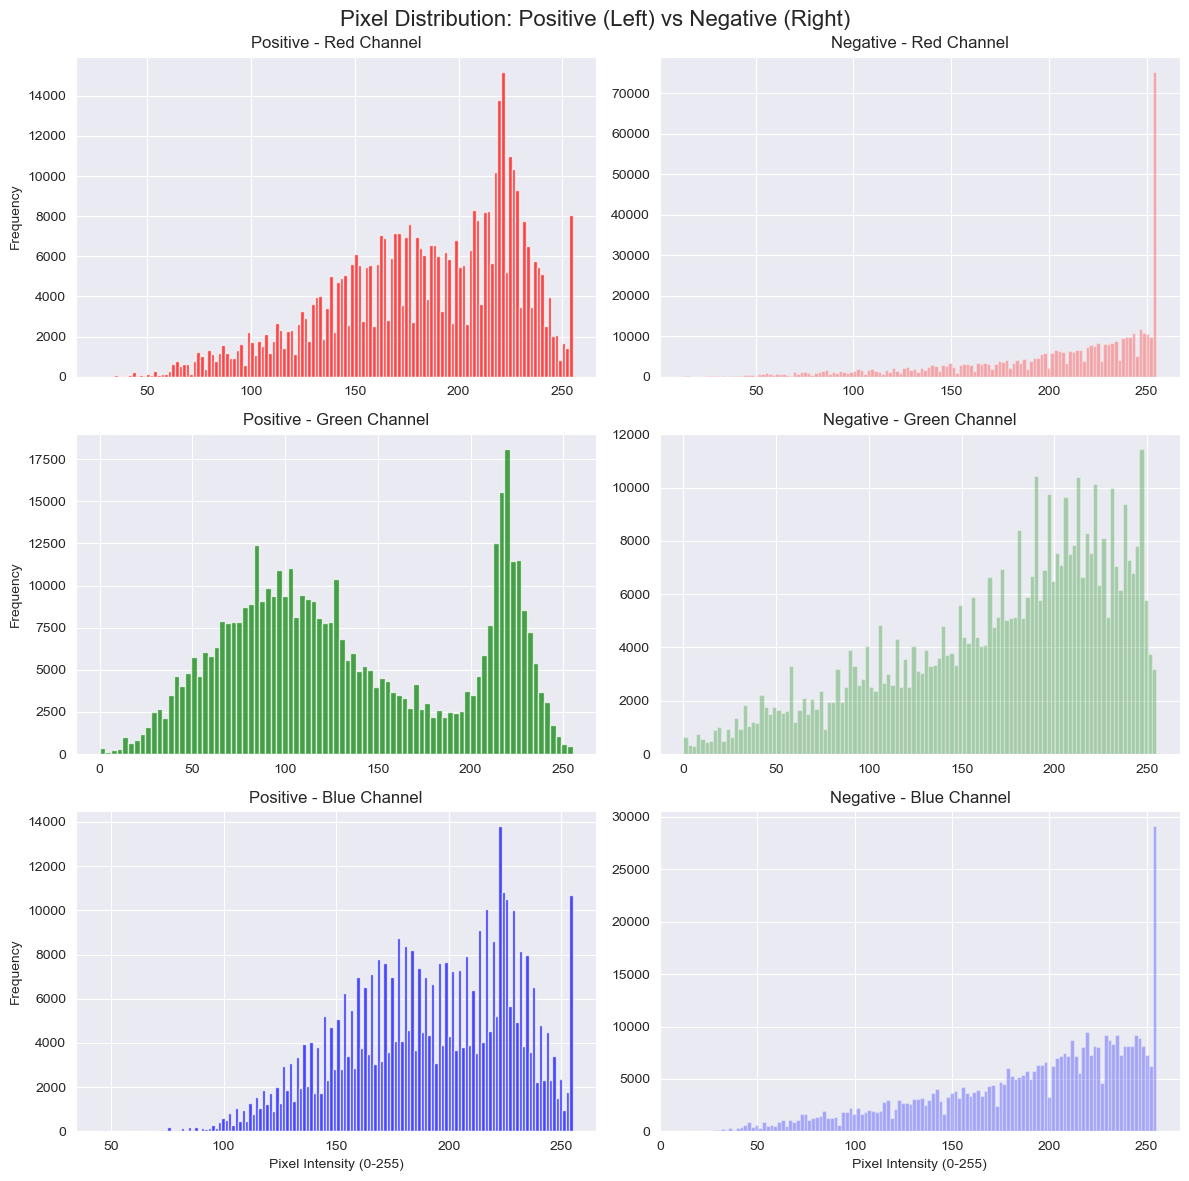

In [3]:
# Actually load the image and analyze the pixels in the dataset
print(f'Images have the following shape when loaded {img_pos.shape}')
# what is the minimum and maximum numbers within the each pixel
print(f"The minimum pixel value is {img_pos.min()} and max is {img_pos.max()} so we are dealing with 8 bit images")

# Plot a distribution of all of the positive and negative pixels in the training data

sample_size = 50 # get the pixel distribution of 10 images
# get a random set of 500 images from each set
subset_pos_plot = rand_pos_set.sample(frac=1, random_state=42).reset_index(drop=True).iloc[:sample_size,0]
subset_neg_plot = rand_neg_set.sample(frac=1, random_state=42).reset_index(drop=True).iloc[:sample_size,0]

# Run Function to flatten the green, red and blue channels for positive and negative readings to help with plotting
pos_red, pos_green, pos_blue = get_channel_values(subset_pos_plot, train_dir)
neg_red, neg_green, neg_blue = get_channel_values(subset_neg_plot, train_dir)

# Plot the different distributions
# Create the grid
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Pixel Distribution: Positive (Left) vs Negative (Right)', fontsize=16)

# --- ROW 0: RED CHANNEL ---
# Positive
axs[0, 0].hist(pos_red, bins='auto', color='red', alpha=0.7)
axs[0, 0].set_title("Positive - Red Channel")
axs[0, 0].set_ylabel("Frequency")

# Negative
axs[0, 1].hist(neg_red, bins='auto', color='red', alpha=0.3) # Lighter red for contrast
axs[0, 1].set_title("Negative - Red Channel")


# --- ROW 1: GREEN CHANNEL ---
# Positive
axs[1, 0].hist(pos_green, bins='auto', color='green', alpha=0.7)
axs[1, 0].set_title("Positive - Green Channel")
axs[1, 0].set_ylabel("Frequency")

# Negative
axs[1, 1].hist(neg_green, bins='auto', color='green', alpha=0.3)
axs[1, 1].set_title("Negative - Green Channel")


# --- ROW 2: BLUE CHANNEL ---
# Positive
axs[2, 0].hist(pos_blue, bins='auto', color='blue', alpha=0.7)
axs[2, 0].set_title("Positive - Blue Channel")
axs[2, 0].set_xlabel("Pixel Intensity (0-255)")
axs[2, 0].set_ylabel("Frequency")

# Negative
axs[2, 1].hist(neg_blue, bins='auto', color='blue', alpha=0.3)
axs[2, 1].set_title("Negative - Blue Channel")
axs[2, 1].set_xlabel("Pixel Intensity (0-255)")

plt.tight_layout() # Adjusts spacing so titles don't overlap
plt.show()


## Analysis of the data

After plotting the data, I can see a key set of observations about it:
* Training data is a bit biased towards negative cancer readings, but not by a lot. This should be fine though since it real life positive cancer readings will not be as common as negative ones. Additionally, the presence of so many positive readings in the dataset especially compared to the real world could bias the model towards identifying more positive readings than it should, but that is fine because in this scenario is better for the model to be biased to create false positives than false negatives since we are dealing with cancer diagnosis!
* Images are RGB images since they have 3 channels of 96x96 pixels, and they are 8 bit images. Since each pixel can be as high as 255, I will need to normalize the data in order to help my model train on it. Dealing with large pixel values may make my model's loss function explode, which will make the training go very slow or become `NaN`
* Plotting the pixel distribution is a good idea because pathology slides are chemically stained with Hematoxylin (Purple) and Eosin (Pink), so the color distribution is chemically linked to the presence of cell nuclei and cytoplasm. If cancerous cells (which usually have large, dark nuclei) are present, I expect a shift in the pixel intensity, particularly in the darker ranges. Looking at the pixel distribution, I have the following observations:
    * Pixels for all colors in the negative reading have a big spike at 255, which makes a lot of sense since `255` is pure white, and healthy tissue has empty spaces (lumens, fat cells, or just slide background) which appear white
    * Healthy tissue (stroma/connective tissue) stains Pink. In RGB, Pink is high Red + high Green + high Blue (mostly Red). This explains why the distribution is skewed heavily toward the bright/high end
    * Positive readings are not as skewed to the right as negatives are, and this makes sense since cancerous tissue has a lot more cells, and cell nuclei absorb Hematoxylin, which is a deep Purple/Blue dye, which translates to a lower pixel value in all of the channels
    * Also, in the positive readings, the green channel is heavily skewed to the left, which makes sense since the stain is purple, which absorbs green light; therefore, wherever there is a tumor, the green pixel value drops near zero, which is why the distribution is so skewed towards the left.
    

# DModel Architecture

I plan to have the following model configurations:
* Simple CNN with no tuning hyperparameters and then a dense layer at the end. I am not planning for this to be successful, but it will help me get started with the creation of the model
    * In this case, I plan to use the following structure: 32 conv(3,3) --> relu activation --> Max pooling, and I will do this 3 times with different kernel sizes starting from 32, 64, 128
    * This model is just to understand how the training process works with this data
    * Also, from looking at the confusion matrix of the simple model below, there are a lot of false negatives, which the model should become better at! This indicates biased behavior in the model. The Confusion matrix reveals the model has high precision, but lower recall because it misses many cancer cases
    * In order to improve this performance:
        * Use Class weights to allocate more importance to cancer cases
        * Lowering decision threshold for flagging cancer more easily in the project
* Use CNN with hyperparameter tuning:
    * CNN will have the following structure: Repeating layers of convolutional --> maxpool --> leaky_relu --> batch normalization with 32, 64, 128, and 256 channels
    * Will use 'same' padding so that the model does not lose access to a large portion of the input data
    * Will use leaky relu instead of relu for the activation function. This is because the new model has more layers, and leaky relu helps neurons from dying in deeper nets because it prevents negative weights from completely getting the gradient down to 0
    * Keep the stride = 0 since I am already using maxpooling for downsampling the model and reducing model complexity and as a result, reducing overfitting
    * Will add batch normalization, that way the more complex model can train faster and also, it prevents exploding gradients
    * Before the flatten layer to create a dense neural network, I will also do a 1x1 convolution of 128 channels to decrease the complexity of the model going into the dense neural network because it will decrease channel depth, and also to allow for cross-channel informing network because this will allow different channels to learn how to combine features from other channels
    * I think this model will work better because:
        * It has a 1x1 convolution before the dense layer to reduce dimensionality, which minimizes the risk of overfitting
        * I increased the number of layers (4th layer), which increases the model's receptive field and in turn captures structural tissue patterns
        * I implemented leaky relu activation function to prevent dead gradients during the training of the deeper network
        * I am optimizing the weights so that the model plays more importance to the positive cancer labels since this was a probable in the prior model

 ## Split the Data

In [2]:
# Initial split of the data to support the model training
training_set, validation_set = divide_input_data(df_train_labels)

# Normalize the data using the keras function for this and also  rotate the training
# images to generate more training data and make the model rotation invariant

train_to_use, validation_to_use = normalize_input_data(training_set, validation_set, train_dir, shuffle=True)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Build the different models

In [3]:
# build the different models using keras
import keras
from keras import layers, models

def build_simple_CNN():
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(96, 96, 3)),
        
        # First layer with conv2d and maxpooling
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Second layer with conv2d and maxpooling
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Third layer with conv2d and maxpooling
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Classifier with the dense neural network
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def build_complex_CNN():
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(96, 96, 3)),
        
        # First layer with conv2d and maxpooling
        layers.Conv2D(32, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Second layer with conv2d and maxpooling
        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Third layer with conv2d and maxpooling
        layers.Conv2D(128, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(pool_size=(2,2)),

        # # Fourth layer with conv2d and maxpooling
        layers.Conv2D(256, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Fifth layer with conv2d and maxpooling
        # use a 1x1 kernel with 32 channel size to simplify model before dense layer
        layers.Conv2D(128, (1,1), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.5), # add drop out to force generalization in the model

        # Classifier with the dense neural network
        layers.Flatten(),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

## Run the simple model and do appropriate plotting, etc

In [8]:
# Build the simple model and see structure
simple_model = build_simple_CNN()
simple_model.summary()

# add a callback to save the history variable into a folder after training so that I do not have to re-train to get history
# also add a function to generate confusion matrix and also put the plots and model training into functions themselves too
# do the testing wiht the testing data

simple_model.compile(
    optimizer='adam',                 # The standard optimizer
    loss='binary_crossentropy',       # MANDATORY for 0 vs 1 classification
    metrics=['accuracy', keras.metrics.AUC(name='auc')]       # track AUC for the Kaggle score
)

# train the simple model
# Define where to save the best model
from keras.callbacks import CSVLogger
checkpoint_path = "best_model.keras_2"

# Define callback to use the best model from the training epochs
# also save the history file to the callback list
simple_model_training_info = CSVLogger('simple_model_training_log.csv', append=True)

# Add all of the required info to the callback list
callbacks_list = [
    # 1. Save the model whenever Validation AUC improves
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_auc',  # Watch validation AUC
        save_best_only=True,     # Only save if it's better than the previous best
        mode='max',              # We want AUC to be higher (max)
        verbose=1
    ),

    # 2. Stop training if Validation AUC stops improving for 3 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=3,              # Wait 3 epochs before giving up
        restore_best_weights=True
    ),
    simple_model_training_info
]

# if there is a trained file already, use that; otherwise, retrain the model
model_exist_path = checkpoint_path
if os.path.exists(model_exist_path):
    print(f"Found checkpoint: {model_exist_path}; no need to retrain model")
    # load the best weights for the model
    simple_model.load_weights(model_exist_path)
    # retrieve accuracy metrics
    # prevent shuffle so that confusion matrix and other sklearn parameters have the right y_predicted and y_true mappping
    train_to_use, validation_to_use = normalize_input_data(training_set, validation_set, train_dir, shuffle=False)
    validation_to_use.shuffle = False
    validation_to_use.batch_size = 512
    validation_to_use.reset()
    history_results = simple_model.predict(validation_to_use, workers=4, use_multiprocessing=False, verbose=1)
else:
    #model has not been trained, so go ahead and train the model
    print(f"Checkpoint not found at: {checkpoint_path}, so let's train the model")
    # Actually train the model
    EPOCHS = 5 # will only do two epochs to keep things simple and train fast
    print("Starting Training...")
    history = simple_model.fit(
        train_to_use,
        validation_data=validation_to_use,
        epochs=EPOCHS,
        callbacks=callbacks_list,
        workers=4,                 # Use 4 CPU cores to load data
        use_multiprocessing=False, # Must be False on Windows
        max_queue_size=10
    )
    print("Training Finished.")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 128)     

## Train the complex model

In [9]:
# Training and compiling the complex model

# Build the simple model and see structure
complex_model = build_complex_CNN()
complex_model.summary()


# submit to kaggle
# make sure all steps are done



# add a callback to save the history variable into a folder after training so that I do not have to re-train to get history
# also add a function to generate confusion matrix and also put the plots and model training into functions themselves too
# do the testing wiht the testing data

complex_model.compile(
    optimizer='adam',                 # The standard optimizer
    loss='binary_crossentropy',       # MANDATORY for 0 vs 1 classification
    metrics=['accuracy', keras.metrics.AUC(name='auc')]       # track AUC for the Kaggle score
)

# train the simple model
# Define where to save the best model
from keras.callbacks import CSVLogger
# checkpoint_path = "best_complex_model.keras"
checkpoint_path = "bigger_dense_best_complex_model_no_1_1_LAST_ONE.keras_2"

# Implement class weights to make sure the model pays more attention to positive labels
# This will be passed as an input to the complex_model.fit() method
# This will help the model penalize misclassification of positive labels more than negative labels
# I want to do this because I observed in the training with the simple model that I got more False negatives
# than false positives likely due to class imbalance in the training data since I have more negative labels than positive labels
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(training_set['label'].astype(int)),
    y=training_set['label'].astype(int)
)
# Now convert the array to a dictionary required by keras so that the class weights take effect
class_weight_dict = dict(enumerate(class_weights))
print(f"Caclulated the class weights appropriately as: {class_weight_dict}")

# Define callback to use the best model from the training epochs
# also save the history file to the callback list
csv_title = 'complex_last.csv'
complex_model_training_info = CSVLogger(csv_title, append=True)

#Adding a callback to dynamically adjust learning rate
reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,      # Multiply LR by 0.2 (slow down by 5x)
    patience=2,      # Wait 2 epochs before triggering
    min_lr=1e-6,     # Don't go below this
    verbose=1
)
# Add all of the required info to the callback list
callbacks_list = [
    # 1. Save the model whenever Validation AUC improves
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_auc',  # Watch validation AUC
        save_best_only=True,     # Only save if it's better than the previous best
        mode='max',              # We want AUC to be higher (max)
        verbose=1
    ),

    # 2. Stop training if Validation AUC stops improving for 3 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=3,              # Wait 3 epochs before giving up
        restore_best_weights=True
    ),
    reduce_learning_rate,
    complex_model_training_info
]

# if there is a trained file already, use that; otherwise, retrain the model
model_exist_path = checkpoint_path
if os.path.exists(model_exist_path):
    print(f"Found checkpoint: {model_exist_path}; no need to retrain model")
    # load the best weights for the model
    complex_model.load_weights(model_exist_path)
    # retrieve accuracy metrics
    # prevent shuffle so that confusion matrix and other sklearn parameters have the right y_predicted and y_true mappping
    train_to_use, validation_to_use = normalize_input_data(training_set, validation_set, train_dir, shuffle=False)
    validation_to_use.shuffle = False
    validation_to_use.batch_size = 512
    validation_to_use.reset()
    history_results_complex = complex_model.predict(validation_to_use, workers=4, use_multiprocessing=False, verbose=1)
else:
    #model has not been trained, so go ahead and train the model
    print(f"Checkpoint not found at: {checkpoint_path}, so let's train the model")
    # Actually train the model
    EPOCHS = 15 # will only do two epochs to keep things simple and train fast
    print("Starting Training...")
    history_complex = complex_model.fit(
        train_to_use,
        validation_data=validation_to_use,
        epochs=EPOCHS,
        callbacks=callbacks_list,
        class_weight=class_weight_dict,  # Pass the class weights to the fit method
        workers=4,                 # Use 4 CPU cores to load data
        use_multiprocessing=False, # Must be False on Windows
        max_queue_size=10
    )
    print("Training Finished.")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_5 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)      

# Result and Analysis

Results for the simple model
the training accuracy of the model is 0    0.777378
1    0.827332
2    0.850080
3    0.862124
4    0.871259
Name: accuracy, dtype: float64


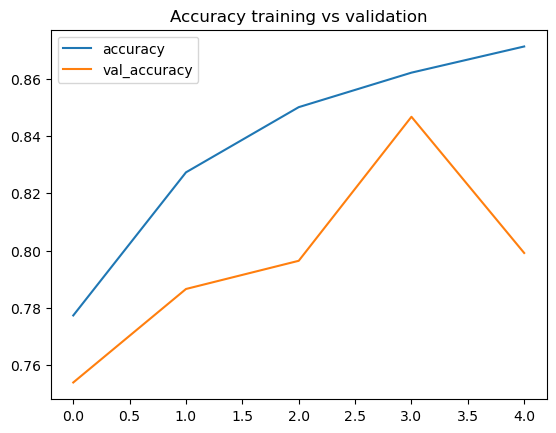

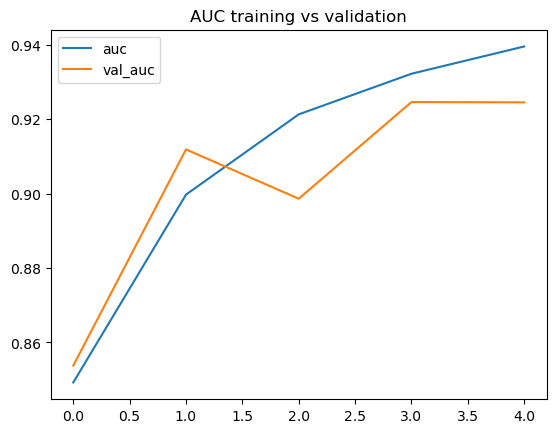

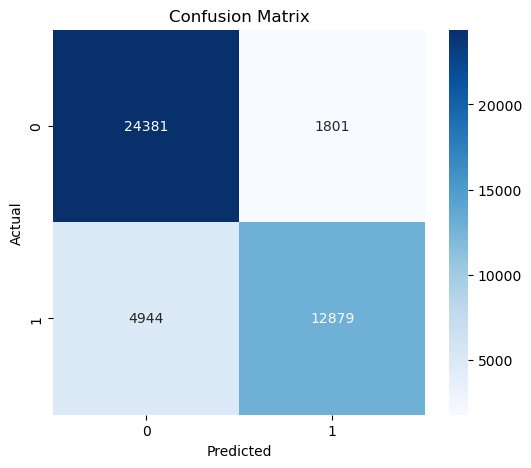

Validation Accuracy: 0.8467
Results for the complex model
the training accuracy of the model is 0     0.838768
1     0.874412
2     0.894705
3     0.907789
4     0.917044
5     0.921753
6     0.927173
7     0.938013
8     0.939910
9     0.941666
10    0.942404
11    0.942916
Name: accuracy, dtype: float64


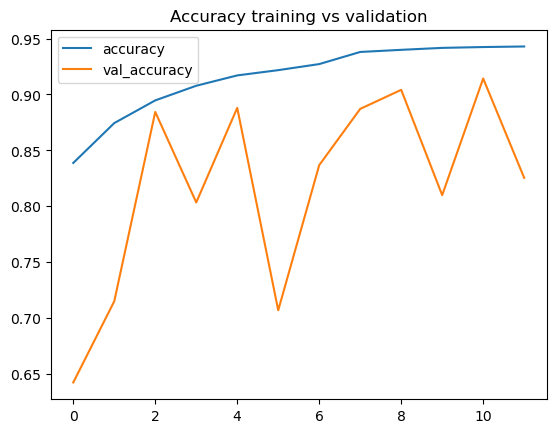

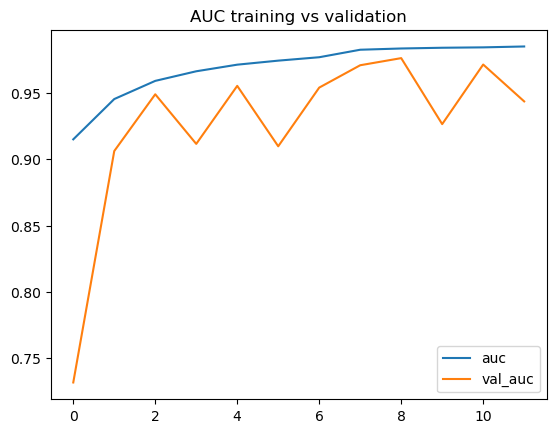

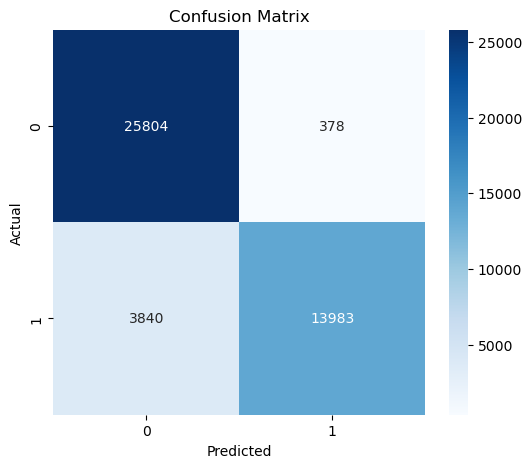

Validation Accuracy: 0.9041


In [18]:
print('Results for the simple model')
# Do some plotting for the simple model
model_plot_generation('simple_model_training_log.csv', 'training')

# Do some plotting for the simple model with validation data
model_plot_generation(history_results, 'validation',val_loader=validation_to_use)

print('Results for the complex model')
# Do some plotting for the complex model
model_plot_generation('complex_last.csv', 'training')

# Do some plotting for the complex model with validation data
model_plot_generation(history_results_complex, 'validation', val_loader=validation_to_use)

## Running the model with the testing data

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# use the complex model to do some data predictions with the test data

test_filenames = os.listdir(test_dir)
# load the test directory into a dataframe
test_df = pd.DataFrame({'filename': test_filenames})

# Now configure the test data generator
# Rescale but no need to generate extra data like before
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create the Test Data Loader
test_loader = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,             # No labels for test data
    batch_size=512,         # Use a large batch size for speed (256 or 512)
    shuffle=False,          # DO NOT SHUFFLE
    class_mode=None,        # We only want the images, not labels
    target_size=(96,96)     # Match your model input
)

# Run Predictions
print(f"Running predictions on {len(test_df)} images...")
predictions = complex_model.predict(test_loader, verbose=1)

# Format for Submission
# The 'predictions' array will be probabilities (0.0 to 1.0). 
# We need to map these back to the image IDs.
submission = pd.DataFrame()
# Remove the '.tif' extension to get the raw ID required by Kaggle
submission['id'] = test_df['filename'].apply(lambda x: x.split('.')[0])
submission['label'] = predictions.flatten() # Convert [[0.1], [0.9]] to [0.1, 0.9]

# 6. Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'.")

# Peek at the first few rows
print(submission.head())

Found 57458 validated image filenames.
Running predictions on 57458 images...
113/113 [==============================] - 575s 5s/step
Submission file saved as 'submission.csv'.
                                         id     label
0  00006537328c33e284c973d7b39d340809f7271b  0.831959
1  0000ec92553fda4ce39889f9226ace43cae3364e  0.259229
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  0.105781
3  000253dfaa0be9d0d100283b22284ab2f6b643f6  0.643391
4  000270442cc15af719583a8172c87cd2bd9c7746  0.001915


 ## Analysis of the Plots and Figures

By looking at the performance of the simple model, I have the following key observations that helped with the design of the more complex model:
* The simple model has a high rate of false negatives, meaning that the model identified a picture as negative for cancer even though it was positive. This is likely due to the fact that there is class imbalance in my training data, which is true when observing that 40.5% of the data is for Positive cancer vs 59.5% for negative cancer. Therefore, in my next model iteration I will plan to correct for that class imbalance
* To improve the accuracy score of the simple model, I plan to add another deeper layer of convolution, and this will increase the receptive field of the model and hopefully allow it to correctly classify those harder images
* Given that the model complexity will increase, I am adding batch normalization, and a final 1x1 convolution before the input into the dense layer in order to achieve dimensionality reduction and optimize the training process
* I am also configuring an adaptive learning rate so that the updates of the weights do not overshoot and miss the right weight values during the training process

For the reasons shared above, I think the more complex model performs better.

Also, a couple of things did not work well:
* Training the model without an adaptive learning rate was causing the model to update the weights with too big of a value, which was causing the validation accuracy of the model to decrease before finishing all of the epochs of the training process
* I also tried a 5x5 kernel size on the last convolutional layer before the 1x1 filter, and this also did not work well, and i believe it was because it was causing the model to overfit the training data while decreasing the AUC and accuracy scores of the validation data.

A couple of things incredibly helped with the performance of the model:
* batch normalization and dropout to prevent overfitting in the model
* Adding deeper layers for the model to improve its accuracy
* Implementing adaptive learning rate to prevent the model from overshooting in the  training process


# Conclusion

Results with the test data: 
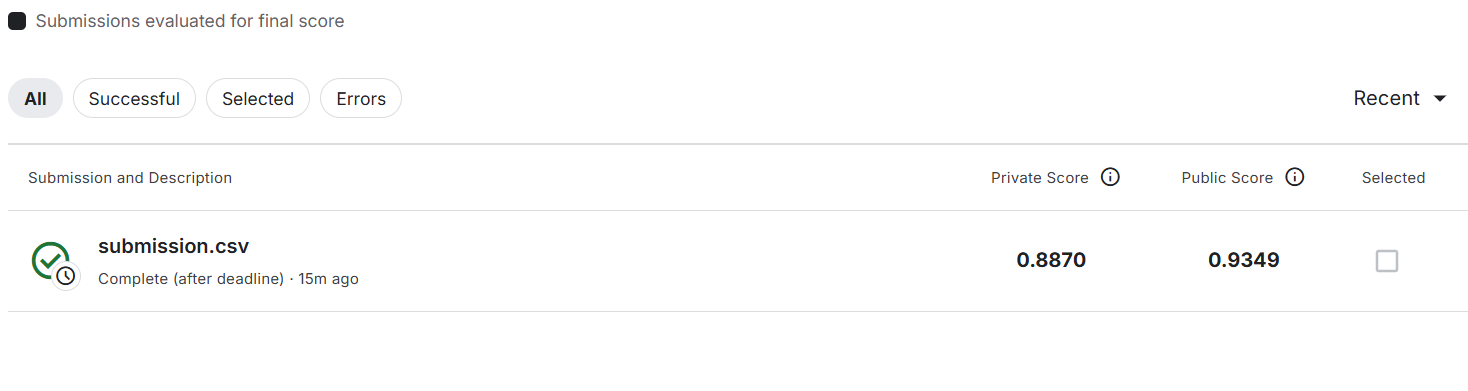

Results interpretation: 
* From looking at the confusion matrix of the model, it seems like my models have a large quantity of false negatives even though I am biasing the weights to pay more attention to the positive for cancer readings. Perhaps, I need to increase the class weights to pay even more importance to the positive readings to begin with
* My testing AUC is close to the validation AUC, which is good because it means that the model is doing a good job at generalizing. This is likely due to the implementation of dropout as well as the 1x1 filter I have before inputting the weights into the dense neural network layer of the model
* Also, by looking at the performance of the model over different epochs, it seems like 10-15 epochs is enough to achieve optimal performance with this architecture since the validation AUC started oscillating rather than improving after the third epoch, which is way an adaptive learning rate is also important because it makes sure to not make the model overshoot once it reaches an optimal solution in one of the epochs

Things that did not help the model learning:
* Increasing the kernel size of the last convolution layer did not help improve model validation AUC and accuracy likely because it was causing the model to over-fit

Thing to potentially try in the future to improve model performance: 
* In the future, I could try to optimize for the class weights that actually achieve the best model performance
* Finding if a bigger kernel size in the earlier networks would help improve the validation AUC without increasing the risk of overfitting within the model

## Links

This code can be found in: https://github.com/Adalberto-Machin/Week-3-CNN-Cancer-Detection-Kaggle-Mini-Project

# References: 
* Gurcan, M. N., Boucheron, L. E., Can, A., Madabhushi, A., Rajpoot, N. M., & Yener, B. (2009). Histopathological image analysis: A review. IEEE Reviews in Biomedical Engineering, 2, 147–171. https://doi.org/10.1109/RBME.2009.2034865